In [525]:
# Final version of the water-filling in 2d space-time.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
# parameters


Nstep = 100 # discretization
f1 = 1e-6 # lowest freq
f2 = 1e0 # highest freq


## equilibrated trapezoid
N = 1 # noise level
threshold = 1e-7 # number of spikes



## tall trapezoid
#N = 1000000 # noise level
#threshold = 2000 # number of spikes


## large trapezoid
#N = 1 # noise level
#threshold = 2*10000000 # number of spikes


## small trapezoid
#N = 0.000001 # noise level
#threshold = 0.1 # number of spikes

In [22]:
# Generate spectrum

X = np.exp(np.linspace(np.log(f1),np.log(f2),Nstep))
T = np.exp(np.linspace(np.log(f1),np.log(f2),Nstep))

GX,GT = np.meshgrid(X[:-1],T[:-1])

# Power density
Ps = 1/(GX**2*GT**2)

P = np.diff(-1/X)[:,np.newaxis]*np.diff(-1/T)[:,np.newaxis].T

print(P.shape)

total_P = np.sum(P)

print(total_P)


(99, 99)
999998000001.0


In [23]:
# compute water filling for a range of lambdas

#lambdas = np.logspace(-30,30,300)
NLAMBDAS= 100
lambdas = np.logspace(12,25,NLAMBDAS)
Ws = list()
for lambd in lambdas:
    F = np.sqrt(N/(lambd*Ps)) - N/Ps #Filter Magnitue Square per mode
    W = P*F #Total water per block
    W[W<0] = 0 
    
    #print(np.sum(W))
    
    Ws.append(W.T)

    #plt.figure()
    #plt.imshow(np.sqrt(W), cmap = 'seismic', vmin = -np.max(np.sqrt(W)), vmax =  np.max(np.sqrt(W)),origin='lower')
    #plt.colorbar()

Ws = np.array(Ws).T
Ws.shape


(99, 99, 100)

In [24]:
# Sum across temporal frequencies (we don't need those)

Nf = np.diff(X)[:,np.newaxis]*np.diff(T)[:,np.newaxis].T

column_Obj = np.sum(P[:,:,np.newaxis]*Ws/(Ws+N*Nf[:,:,np.newaxis]),axis =0)

column_W = np.sum(Ws,axis = 0)

print(column_Obj.shape, column_W.shape)

(99, 100) (99, 100)


In [25]:
# Try to find best box

X1 = 0
best_Obj = 0
best_l1 = 0

for X2 in range(X1+1, len(X)):

        totalObj = np.sum(column_Obj[X1:X2], axis = 0)

        DX = X[X2]-X[X1]
        
        
        
        total_l1 = np.sqrt(DX*(np.sum(column_W[X1:X2], axis = 0)))#+0*N*DX*(f2-f1))

        Obj = np.max(totalObj - 1e30 * np.maximum(total_l1 - threshold, 0))

        W = np.argmax(totalObj - 1e30 * np.maximum(total_l1 - threshold, 0))
        
        
        
        
        if X2==20:
            print(100*(total_P -  totalObj[W])/total_P)
            print(Obj)
            print(totalObj[W])
            print('')
            
        if X2==24:
            print(100*(total_P -  totalObj[W])/total_P)
            print(Obj)
            print(best_Obj)
            print(totalObj[W])


        if Obj>best_Obj:
            best_W = W
            best_Obj = totalObj[W]
            best_l1 = total_l1[W]
            best_REC = (total_P -  best_Obj)/total_P
            best_DX = DX
            best_X = X2
print('')
print(threshold)
print(best_REC*100,'% error in reconstruction')
print(best_l1, 'L1')
print(best_W)
print(best_DX, best_X)
print(best_Obj)

18.5925674685
814072697167.0
814072697167.0

22.6563689026
773434764102.0
827968938495.0
773434764102.0

1e-07
17.2029405565 % error in reconstruction
9.72112865553e-08 L1
58
9.7226722201e-06 17
827968938495.0


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


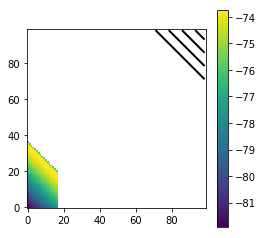

In [26]:


W = Ps*F
W[W<0] = 0


plt.figure(figsize = (4,4))

plt.contour(P, np.logspace(-4,0,10), linewidths = 2, linestyles = 'solid', colors = 'k')

Fk = Ws[:,:,best_W]/Ps
Fk[:,best_X:] = 0

#plt.imshow(np.sqrt(Fk), cmap = 'bwr', vmin = -np.max(Fk), vmax =  np.max(Fk),origin='lower')
#plt.colorbar()

plt.imshow(np.log(Fk),origin='lower')
plt.colorbar()


#plt.savefig('foo.eps')

In [27]:
# Find best box for two types


X1 = 0
best_Obj = 0
best_l1 = 0

for X2 in range(X1+1, len(X)):
    for X3 in range(X2+1,len(X)):

        Obj1 = np.sum(column_Obj[X1:X2], axis = 0)
        Obj2 = np.sum(column_Obj[X2:X3], axis = 0)

        totalObj = Obj1[:,np.newaxis] + Obj2[:,np.newaxis].T

        DX1 = X[X2]-X[X1]
        DX2 = X[X3]-X[X2]

        l1_1 = np.sqrt(DX1*np.sum(column_W[X1:X2], axis = 0))
        l1_2 = np.sqrt(DX2*np.sum(column_W[X2:X3], axis = 0))

        total_l1 = (l1_1[:,np.newaxis]+l1_2[:,np.newaxis].T)

        Obj = np.max(totalObj - 1e17 * np.maximum(total_l1 - threshold, 0))

        W = np.argmax(totalObj - 1e17 * np.maximum(total_l1 - threshold, 0))

        W1 = W // Obj1.shape[0]
        W2 = W % Obj1.shape[0]

        if Obj>best_Obj:
            best_Obj = totalObj[W1,W2]
            best_l1 = total_l1[W1,W2]
            best_X1 = X1
            best_X2 = X2
            best_X3 = X3
            best_W1 = W1
            best_W2 = W2
            best_DX1 = DX1
            best_DX2 = DX2
            best_REC = (total_P -  best_Obj)/total_P

print(threshold)
print(best_REC*100,'% error in reconstruction')
print(best_DX2/(best_DX1+best_DX2)*100,'% midget cells')
print(best_l1, 'L1')
print(best_W1, best_W2, 'warning')
print(best_DX1, best_DX2, 'densities')
print('')



1e-07
8.69284893258 % error in reconstruction
99.0210366812 % midget cells
3.36673862706e-07 L1
43 48 warning
1.49756995398e-07 1.51477513508e-05 densities



/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log


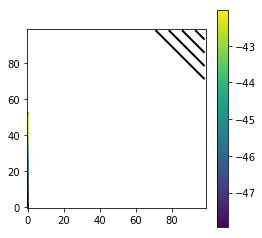

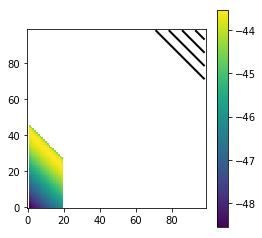

In [28]:

NTYP = 2
W = P*F
W[W<0] = 0

for i in range(NTYP):
    plt.figure(figsize = (4,4))

    plt.contour(P, np.logspace(-4,0,10), linewidths = 2, linestyles = 'solid', colors = 'k')
    
    
    if i == 0:
        Fk = Ws[:,:,best_W1]/P
        #Fk = Ws[:,:,best_W1]/(Ws[:,:,best_W1]+N)
        Fk[:,0:best_X1] = 0
        Fk[:,best_X2:] = 0
    else:
        Fk = Ws[:,:,best_W2]/P
        #Fk = Ws[:,:,best_W2]/(Ws[:,:,best_W2]+N)
        Fk[:,0:best_X2] = 0
        Fk[:,best_X3:] = 0
        
    plt.imshow(np.log(Fk),origin='lower')
    plt.colorbar()
    
    #plt.imshow(Fk, cmap = 'bwr', vmin = -np.max(Fk), vmax =  np.max(Fk),origin='lower')
    #plt.colorbar()


#plt.savefig('foo.eps')

In [29]:
37/66

0.5606060606060606